# Introduction to Neuroinformatics


## Exercise session 7 (Part 2): Analyzing Representations in Deep Networks

In this last section, we explore how a deep neural network represents data across its different layers. To that end, we will be using techniques similar to what we have used so far for neural recordings. You will explore how the network transforms high-dimensional image data layer by layer, and how representations change in this process.

We will be using a artifical network (CNN, convolutional neural network) pre-trained to classify images. We will again be using AlexNet like in a previous exercise.


---

# Table of contents
* [Packages](#packages)
* [3: Alexnet (Again!)](#alex)
  * [3.1: RSA - Representational Similarity Analysis](#rsa)
      * [3.1.1: First-order Similarity Matrices](#first)
      * [3.1.2: Second-order Similarity Matrix](#second)
  * [3.2: PCA - Principal Component Analysis](#pca)



---

# Packages <a name="packages"></a>
The following cells are used to install the necessary packages and libraries for the exercise:


In [ ]:
!which python  # This displays which python is being used
!pwd # This displays the current directory

/usr/local/bin/python
/content


In [ ]:
import zipfile
from urllib.request import urlretrieve

files = [
    ('https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex7/utils_2.py', 'utils_2.py'),
    ('https://polybox.ethz.ch/index.php/s/MpcSLFUgK3SVXUP/download', 'imagenet.zip')
]

for url, filename in files:
    urlretrieve(url, filename)

with zipfile.ZipFile('imagenet.zip', 'r') as zf:
    zf.extractall('.')

!pip3 install --quiet ipympl

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils_2 import *

---

# 3. AlexNet (Again!) <a name="alex"></a>

---

> **Assignment 21**
>
> Before we start our journey, what is your intuition of how the dimensionality of the representations changes as we move through the CNNs layers? Should it stay the same, decrease, or increase?
> <details>
> <summary>Solution</summary>
>
> Since we were asking for your intuition, there's no strictly right or wrong answer here. One answer could be: *The input has dimensions 224 × 224 × 3 (image resolution × RGB). The output has dimension 1000 (number of classes). Somewhere along the way, I expect the dimensionality to reduce.*
> </details>

---

In [ ]:
convolutional_neural_net = load_cnn_model()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Alexnet consists of the following layers:

In [ ]:
convolutional_neural_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
images, labels = load_imagenet_sample()

We have now loaded a batch of images from the dataset. Let's have a look at them. We have four distinct classes: *chain saw*, *french horn*, *gas pump*, and *golf ball* (one row for each).



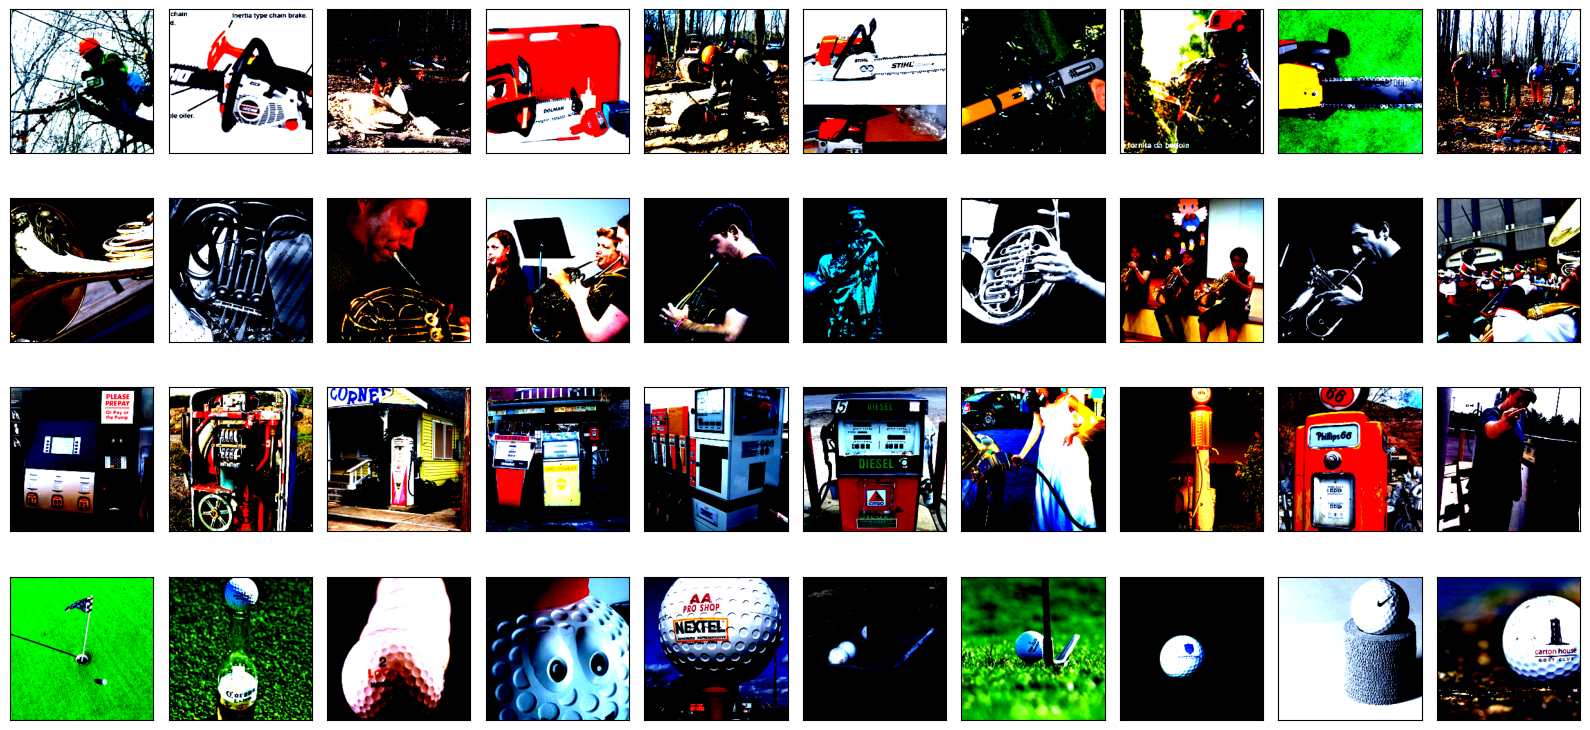

In [ ]:
%matplotlib inline

plot_images_grid(images, labels)

---

> **Assignment 22**
>
> Looking at these images, what are the features that you think could be useful to classify them into different categories? Think of both low level features (edges, colors), and high level features (shapes, faces, objects).
> <details>
> <summary>Solution</summary>
>
> There's many possible answers, a few of them here:
>
> #### Low level features:
>   - *Chain saw*: red pixels, high energy in fourier space for certain frequencies of vertical edges (background trees)
>   - *French horn*: yellow pixels, small white peaks (specular reflections)
>   - *Gas Pump*: smooth uniform textures/areas
>   - *Golf Ball*: green pixels, white pixels, dimple texture
>
> #### Higher level features:
>   - *Chain saw*: oblong outline
>   - *French horn*: spiral shape, presence of faces
>   - *Gas Pump*: (affine transforms of) rectangular shapes
>   - *Golf Ball*: circular outline (Hough transform)
> </details>

---

## 3.1: RSA - Representational Similarity Analysis <a name="rsa"></a>

*Representational Similarity Analysis* is a way to compare how "close" the representation of data is between (in our case) two different layers of the network. The nice thing about RSA is that it doesn't care about how the units in layer N relate to the units in layer N + 1. RSA doesn't care if the two layers have different number of units. If you want, you can even use RSA to compare two completely different modalities like fMRI data with CNN activation data.



---

### 3.1.1: First-order Similarity Matrices <a name="first"></a>

To that end, we first record activity for a fixed set of *n* images/stimuli, and then build an *n* × *n* similarity matrix that shows us how similar the activations were for a given pair of stimuli. We measure similarity here through correlation.



---

> **Assignment 23**
>
> Why use correlation to measure similarity instead of using e.g. euclidean distance? What might be the advantages of doing it this way?
> <details>
> <summary>Solution</summary>
>
> In neural data, there might be some "noise" that, for the same stimulus but different trial, might shift the baseline activity, or absolute scale of activity. Euclidean distance is sensitive to these changes. But we care more about which units fire together, regardless of scale or baseline activity. Correlation shows us when the same units fire together, while ignoring scale or mean activity.
> </details>

---

In order to give the similarity matrices a more interesting and interpretable structure, we will order the images first by class, and within each of the four classes, the first half will be images with high redness, while the second half will have very low redness:

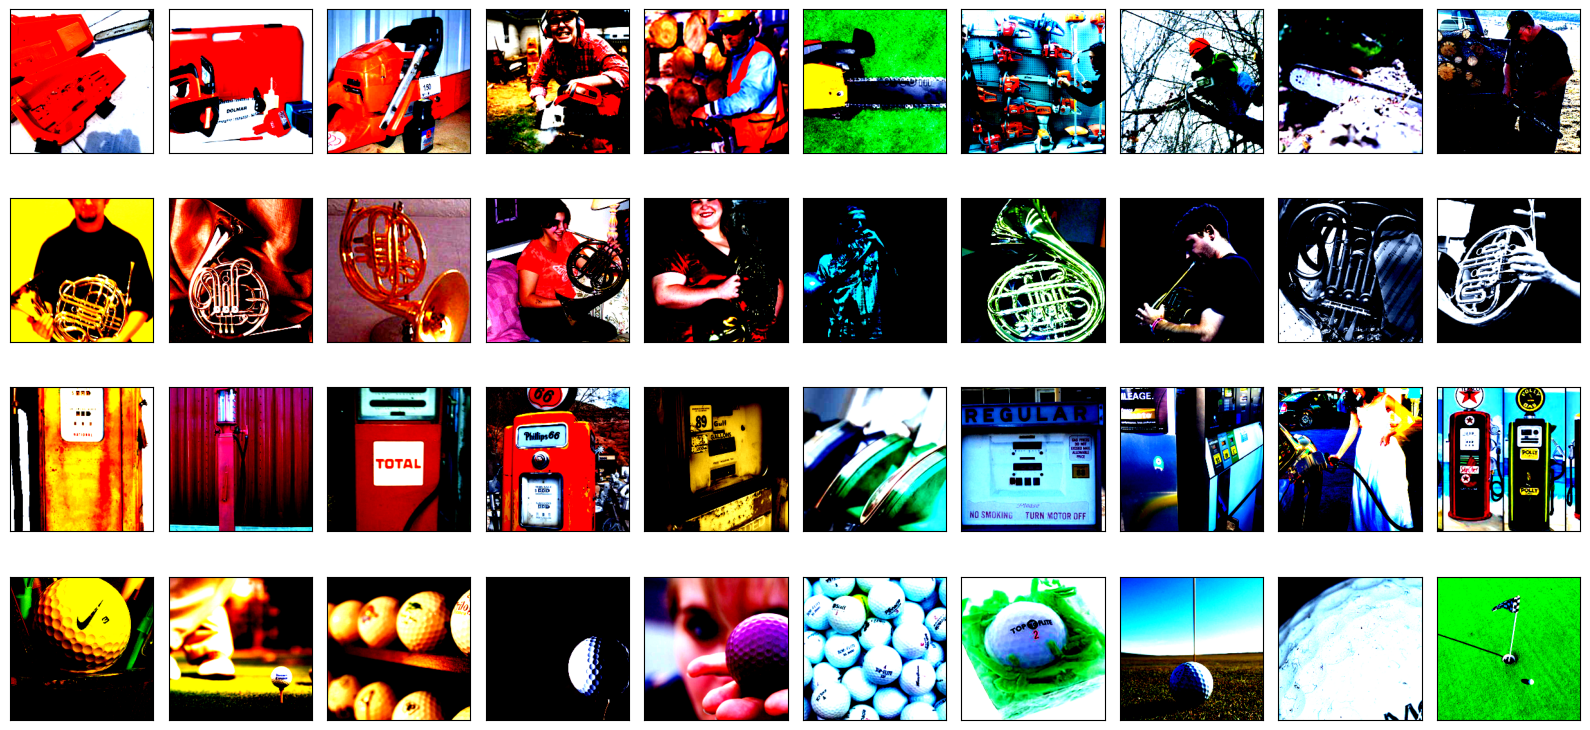

In [ ]:
%matplotlib inline

redness_images, redness_labels = pick_redness_extrema(images, labels)
plot_images_grid(redness_images, redness_labels)

Now for this data, let us get the activations for each layer, for each image:

In [ ]:
batch_activations = get_activations_with_names(convolutional_neural_net, redness_images)

In [ ]:
def get_similarity_matrix(batch_activation):
    similarity_matrix = np.corrcoef(batch_activation.flatten(start_dim=1))
    return similarity_matrix

In [ ]:
similarity_matrices = {
    layer_name: get_similarity_matrix(layer_batch_activation) for layer_name, layer_batch_activation in batch_activations.items()
}

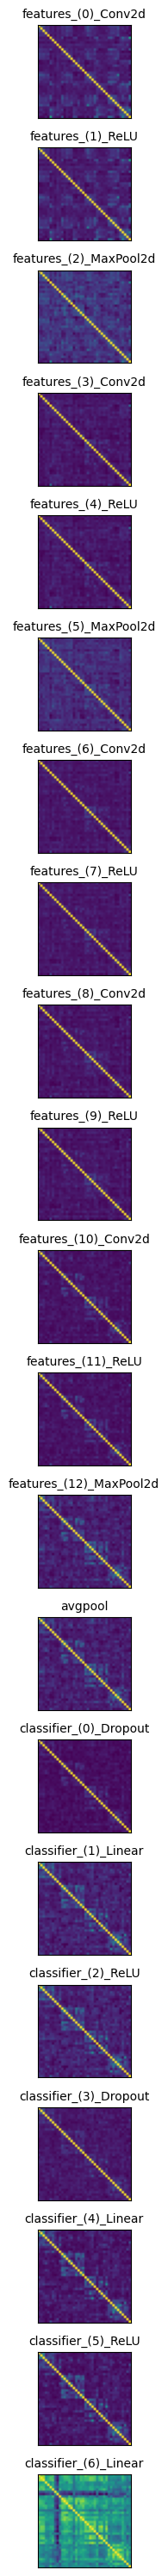

In [ ]:
%matplotlib inline

plot_similarity_matrices_col(similarity_matrices)

---

> **Assignment 24**
>
> When you look at the at the similarity matrices across layers, are there any interesting changes you can notice? What do they mean?
> <details>
> <summary>Solution</summary>
>
> In the first layers, we can see a block structure on the diagonal with eight blocks. This corresponds to the red/non-red subgroups, so the first few layers seem to care a lot about this low level color feature. In the last layers, we can see a block structure on the diagonal with four blocks. This corresponds to the four class groups, meaning that the last layers care about high level concepts like french horn vs chain saw.
> </details>

---

### 3.1.2: Second-order Similarity Matrix <a name="second"></a>

The first-order similarity matrices we calculated above give us an insight of how similarly two given stimuli are represented in one layer. Using the fact that for each layer, we have now the same shape *n* × *n* for its similarity matrix, we can now compare layers by comparing their first-order similarity matrices. We again do this in the form of a similarity matrix, this time we call it second-order similarity matrix. As a measure of similarity between two first-order matrices, we will use the Spearman correlation between their entries. This second-order similarity matrix gives us an insight of how representations change between layers.



---

> **Assignment 25**
>
> What does it mean when two layers have high second-order similarity? What does it mean when they have low similarity?
> <details>
> <summary>Solution</summary>
>
> When two layers have high second-order similarity, it means that how stimuli relate to each other is preserved between layers. E.g. if pictures of cats cluster close to each other, and away from pictures of dogs in one layer, we should see the same in the other layer. On the other hand, when two layers have low second-order similarity, we should see the opposite: How stimuli relate to each other is not preserved. This could be the case if one layer clusters images based on color, and the other layer clusters them based on classes.
> </details>


---

> **Assignment 26**
>
> Why do we use correlation for the first-order similarity matrices, but Spearman correlation for the second-order similarity matrix?
> <details>
> <summary>Solution</summary>
>
> In first-order similarity matrices, we care about patterns of activations. We are using normal, linear correlation because we want to capture exact magnitudes of similarity between activity patterns. On the other hand, in the second-order similarity matrix, we care about whether or not the representational geometry is conserved. Here we care for example about the closeness of one particular cat picture to all the other cat pictures, versus its larger distance to the dog cluster, is preserved from one layer to the other. We just care that one distance is shorter than the other, so we care about rank, and that is why we use Spearman correlation. (The original paper on RSA also gives the argument that certain types of noise can transform similarity nonlinearly but monotonically, again favouring Spearman over ordinary correlation)
> </details>

---

In [ ]:
from scipy.stats import spearmanr

def spearman_corrcoef(matrix):
    corr, _ = spearmanr(matrix, axis=1)
    return corr

In [ ]:
def extract_lower_tri_entries(matrix):
    lower_tri_indices = np.tril_indices_from(matrix, k=-1)
    lower_tri_entries = matrix[lower_tri_indices]
    return lower_tri_entries.flatten()

In [ ]:
flattened_similarity_matrices = np.array([extract_lower_tri_entries(sm) for sm in similarity_matrices.values()])
second_order_similarity_matrix = spearman_corrcoef(flattened_similarity_matrices)

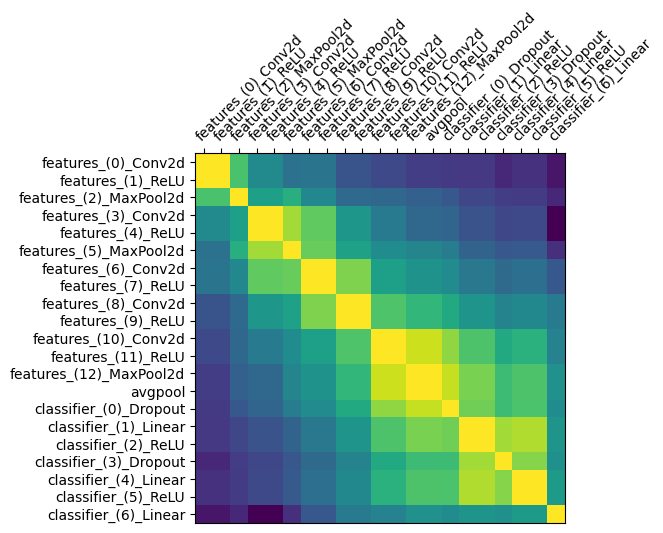

In [ ]:
%matplotlib inline

plot_second_order_similarity_matrix(second_order_similarity_matrix, similarity_matrices.keys())

---

> **Assignment 27**
>
> When you look at the second-order similarity matrix, can you see any clear groups of layers?
> <details>
> <summary>Solution</summary>
>
> - Close layers seem to be similar, distant layers dissimilar
> - The last convolutional layer, together with the whole classifier, seem to form a block on the diagonal
> </details>


---

> **Assignment 28**
>
> Can you see a pattern how different *types* of layers tend to be similar, or dissimilar?
> <details>
> <summary>Solution</summary>
>
> Conv2d/ReLU pairings and Linear/ReLU pairings have high similarity. If you think about how the Pearson correlation is computed, this makes sense: ReLU is just the input, transformed by a (mostly invertible) nonlinearity. Pearson cares about rank, and rank mostly preserved by ReLU (except for the flat part of ReLU). So we do expect high Pearson correlation here. However, the perfect correlation of 1 that we see here is actually due to a technical detail: The ReLU layers in Alexnet as loaded directly from pytorch have ReLU configured with inplace=True, so the ReLU activations overwrite the previous layer activations.
> </details>

---

## 3.2: PCA - Principal Component Analysis <a name="pca"></a>

Just like we used PCA to analyze neural population responses before, we can apply it again layer by layer to understand how the nature of the representation changes as we go through the layers.

In [ ]:
from numpy.linalg import svd

def PCA(data_matrix):
    data_matrix = np.array(data_matrix)
    data_centered = data_matrix - np.mean(data_matrix, axis=0)
    U, S, Vt = svd(data_centered, full_matrices=False)

    principal_components = Vt
    num_samples = data_matrix.shape[0]
    variance_explained = (S ** 2) / (num_samples - 1)
    cumulative_variance_explained = np.cumsum(
        variance_explained / variance_explained.sum()
    )

    return principal_components, variance_explained, cumulative_variance_explained

Let us do PCA on the original, full batch of images to have sufficient statistics for PCA:



In [ ]:
batch_activations = get_activations_with_names(convolutional_neural_net, images, subsample=1000)

pcs = {
    layer_name: PCA(layer_batch_activation) for layer_name, layer_batch_activation in batch_activations.items()
}

---

> **Assignment 29**
>
> Here we are subsampling a thousand units in each layer. Why would we do this?
> <details>
> <summary>Solution</summary>
>
> For PCA, we need at least as many samples as the dimensionality of the data (ideally more, e.g. >10x). The layers we are looking at have up to ~200k units, so we would need to do inference on at least that many images, and then PCA on a much larger dataset. We don't want to wait minutes or hours for our result here, that's why we subsample.
> </details>

---

Explore how much of the variance explained is concentrated in the first few components, for different layers:

In [ ]:
plot_variance_explained(pcs)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Layer #', layout=Layout(width='…

To have a more quantitative insight into the dimensionality of representations in each layer according to PCA, we compute how many principal components are necessary to get to 80% cumulative variance explained, for each layer:


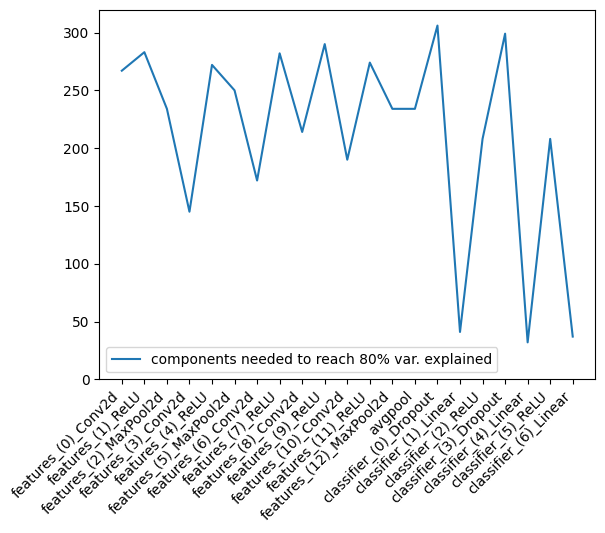

In [ ]:
%matplotlib inline

dimensionality = {
    layer_name: np.argwhere(cum_var_explained > .8).min() for layer_name, (*_, cum_var_explained) in pcs.items()
}

plt.plot(dimensionality.keys(), dimensionality.values(), label='components needed to reach 80% var. explained')
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=0.)
plt.legend();

---

> **Assignment 30**
>
> What can you say about the dimensionality of each layer, as you go through the network?
> <details>
> <summary>Solution</summary>
>
> We know that the input to the network is very high-dimensional (a draw from the imagenet dataset). We see that dimensionality according to PCA and our 80% cumulative variance explained criterion stays high during the features/convolutional part, and then progressively decreases during the classifier/fully-connected part. As we go deeper in the classifier, the layers represent more and more class specific features, ending with a vector representing the class at the end. We know that the final layer *classifier_(6)_Linear* is probably quite low-dimenisonal, because calculating the softmax of that layer should give us one of four 1-hot vector corresponding to the four classes.
> </details>

---

---

# End of this exercise session